# Spatiotemporal Modelling with SPDEs

In this tutorial, we will demonstrate how to perform spatiotemporal Bayesian
inference using GMRFs based on a simple toy example.

## Problem setup
Our goal is to model how a pollutant (i.e. some chemical) spreads across a
river over time.
We get (noisy) measurements of the pollutant concentration across the domain
at time t = 0, and an additional measurement at some later point in time.
To simplify things, we model the river as a 1D domain.
Let's set up the problem:

In [1]:
x_left, x_right = -1.0, 1.0
Nₓ = 201
t_start, t_stop = 0.0, 1.0
Nₜ = 71
ts = range(t_start, t_stop, length = Nₜ)
f_initial = x -> exp(-(x + 0.6)^2 / 0.2^2)
xs_initial = range(x_left, x_right, length = Nₓ ÷ 2)
ys_initial = f_initial.(xs_initial)
noise_precision_initial = 0.1^(-2)

x_later = -0.25
y_later = 0.55
noise_precision_later = 0.01^(-2)

xs_all = [xs_initial; x_later]
ys_all = [ys_initial; y_later]
N_obs_all = length(ys_all)

101

## Using GMRFs for spatiotemporal modelling
Fundamentally, we are interested in inferring a spatiotemporal function that
models the pollutant concentration over time, which is an infinite-dimensional
object.
GMRFs, however, are finite-dimensional.
This is not a limitation, it just means that we need to discretize space and
time to ultimately obtain a discrete approximation to the infinite-dimensional
object.

We're going to do this as follows:
1. Set up a stochastic PDE (SPDE) that models the spatiotemporal,
   infinite-dimensional prior (a Gaussian process).
2. Discretize the SPDE in space and time to obtain a GMRF which approximates
   the Gaussian process.
3. Condition the GMRF on the observations to obtain the posterior.

Let's start by setting up our discretizations:

In [2]:
using GaussianMarkovRandomFields
using Ferrite

grid = generate_grid(Line, (Nₓ - 1,), Tensors.Vec(x_left), Tensors.Vec(x_right))
interpolation = Lagrange{RefLine, 1}()
quadrature_rule = QuadratureRule{RefLine}(2)
disc = FEMDiscretization(grid, interpolation, quadrature_rule)

FEMDiscretization
  grid: Grid{1, Line, Float64} with 200 Line cells and 201 nodes
  interpolation: Lagrange{RefLine, 1}()
  quadrature_rule: QuadratureRule{RefLine, Vector{Float64}, Vector{Vec{1, Float64}}}
  # constraints: 0


## A separable model
Perhaps the simplest spatiotemporal model is a separable one, where the
spatial and temporal components are independent.
We can model both the spatial and temporal components using Matern processes:

In [3]:
spde_space = MaternSPDE{1}(range = 0.2, smoothness = 1, σ² = 0.3)
spde_time = MaternSPDE{1}(range = 0.5, smoothness = 1)

MaternSPDE{1, Float64, Int64}(6.928203230275509, 3//2, 1.0, [1.0;;])

Discretize:

In [4]:
x_space = discretize(spde_space, disc)
Q_s = precision_map(x_space)

grid_time = generate_grid(Line, (Nₜ - 1,), Tensors.Vec(t_start), Tensors.Vec(t_stop))
disc_time = FEMDiscretization(grid_time, interpolation, quadrature_rule)
x_time = discretize(spde_time, disc_time)
Q_t = precision_map(x_time)

71×71 LinearAlgebra.Symmetric{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}:
   778.623  -1036.46     257.853  …       ⋅          ⋅          ⋅ 
 -1036.46    1815.1    -1036.46           ⋅          ⋅          ⋅ 
   257.853  -1036.46    1557.25           ⋅          ⋅          ⋅ 
      ⋅       257.853  -1036.46           ⋅          ⋅          ⋅ 
      ⋅          ⋅       257.853          ⋅          ⋅          ⋅ 
      ⋅          ⋅          ⋅     …       ⋅          ⋅          ⋅ 
      ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
      ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
      ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
      ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
     ⋮                            ⋱                            ⋮
      ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
      ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
      ⋅          ⋅          ⋅             ⋅  

Create the separable spatiotemporal model:

In [5]:
x_st_kron = kronecker_product_spatiotemporal_model(Q_t, Q_s, disc)

MetaGMRF{ConcreteSTMetadata}
  Inner GMRF: GMRF{Float64}(n=14271, alg=LinearSolve.DefaultLinearSolver)
  Metadata: ConcreteSTMetadata{1}(201 spatial × 71 time)

Great! Now let's condition on the observations.
To do this, we construct a "spatial" observation matrix and transform it into
a "spatiotemporal" observation matrix:

In [6]:
A_initial = evaluation_matrix(disc, [Tensors.Vec(x) for x in xs_initial])
t_initial_idx = 1 # Observe at first time point
A_initial = spatial_to_spatiotemporal(A_initial, t_initial_idx, Nₜ)
A_later = evaluation_matrix(disc, [Tensors.Vec(x_later)])
t_later_idx = 2 * Nₜ ÷ 3
A_later = spatial_to_spatiotemporal(A_later, t_later_idx, Nₜ)

A_all = [A_initial; A_later]

using LinearAlgebra, SparseArrays
Q_noise = sparse(I, N_obs_all, N_obs_all) * noise_precision_initial
Q_noise[end, end] = noise_precision_later

10000.0

Condition on the observations:

In [7]:
x_st_kron_posterior = condition_on_observations(x_st_kron, A_all, Q_noise, ys_all)

MetaGMRF{ConcreteSTMetadata}
  Inner GMRF: GMRF{Float64}(n=14271, alg=LinearSolve.DefaultLinearSolver)
  Metadata: ConcreteSTMetadata{1}(201 spatial × 71 time)

Let's look at the dynamics of this posterior.

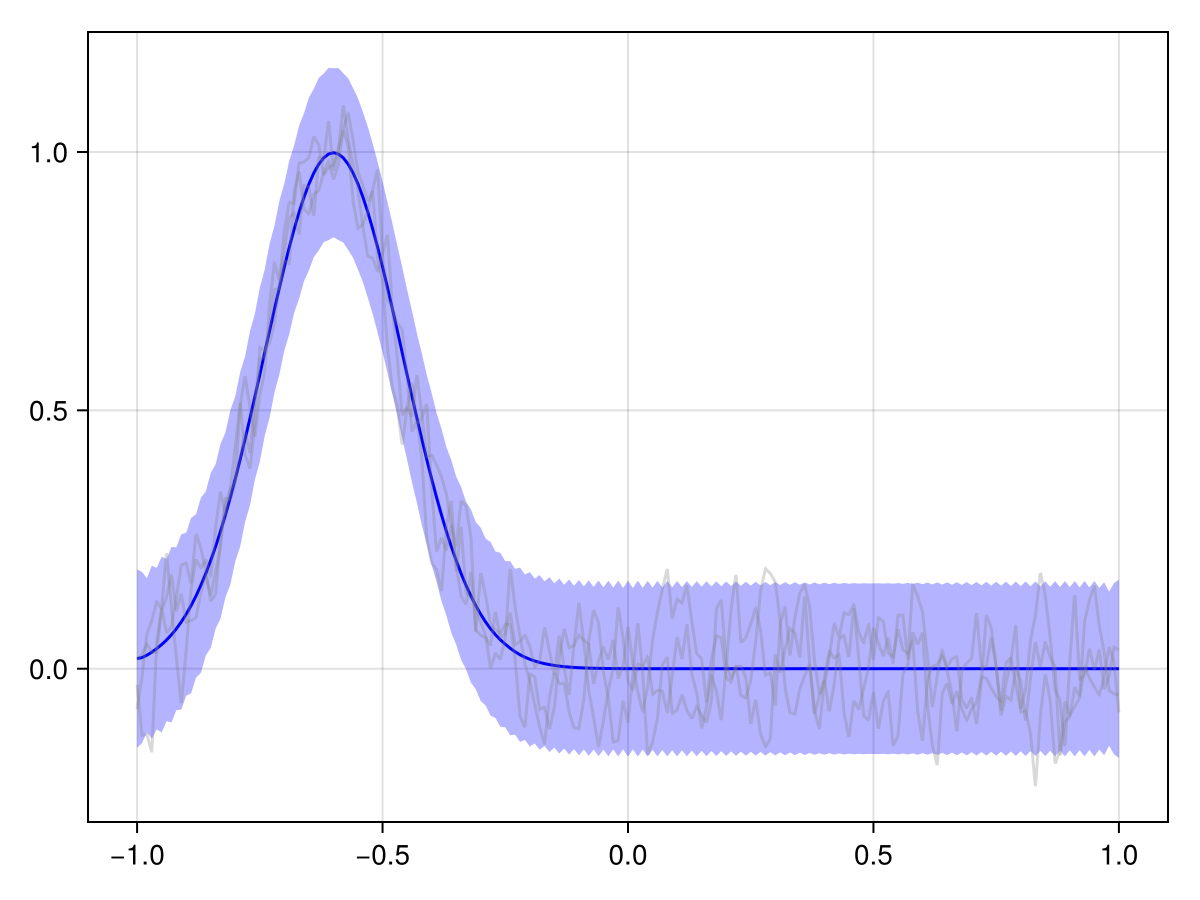

In [8]:
using CairoMakie
CairoMakie.activate!()
plot(x_st_kron_posterior, t_initial_idx)

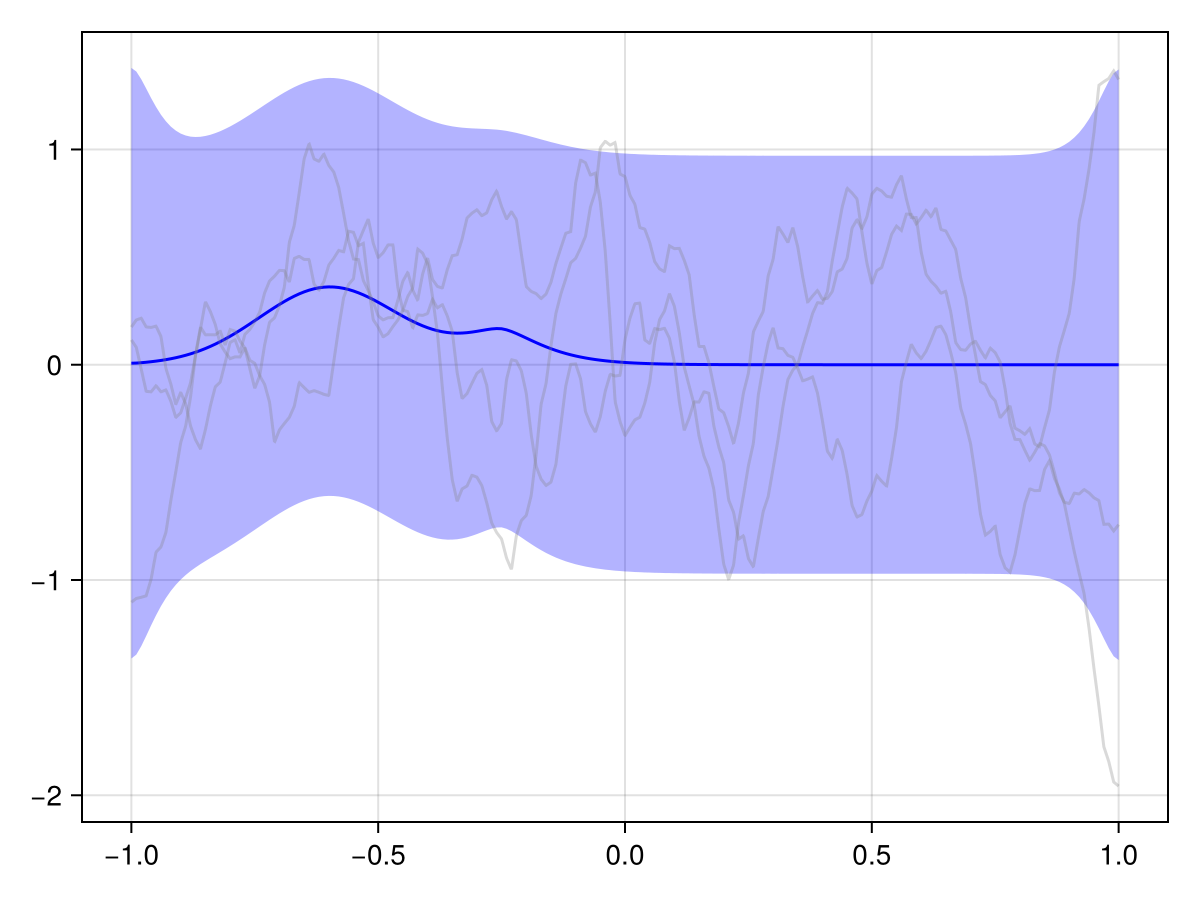

In [9]:
plot(x_st_kron_posterior, Nₜ ÷ 3)

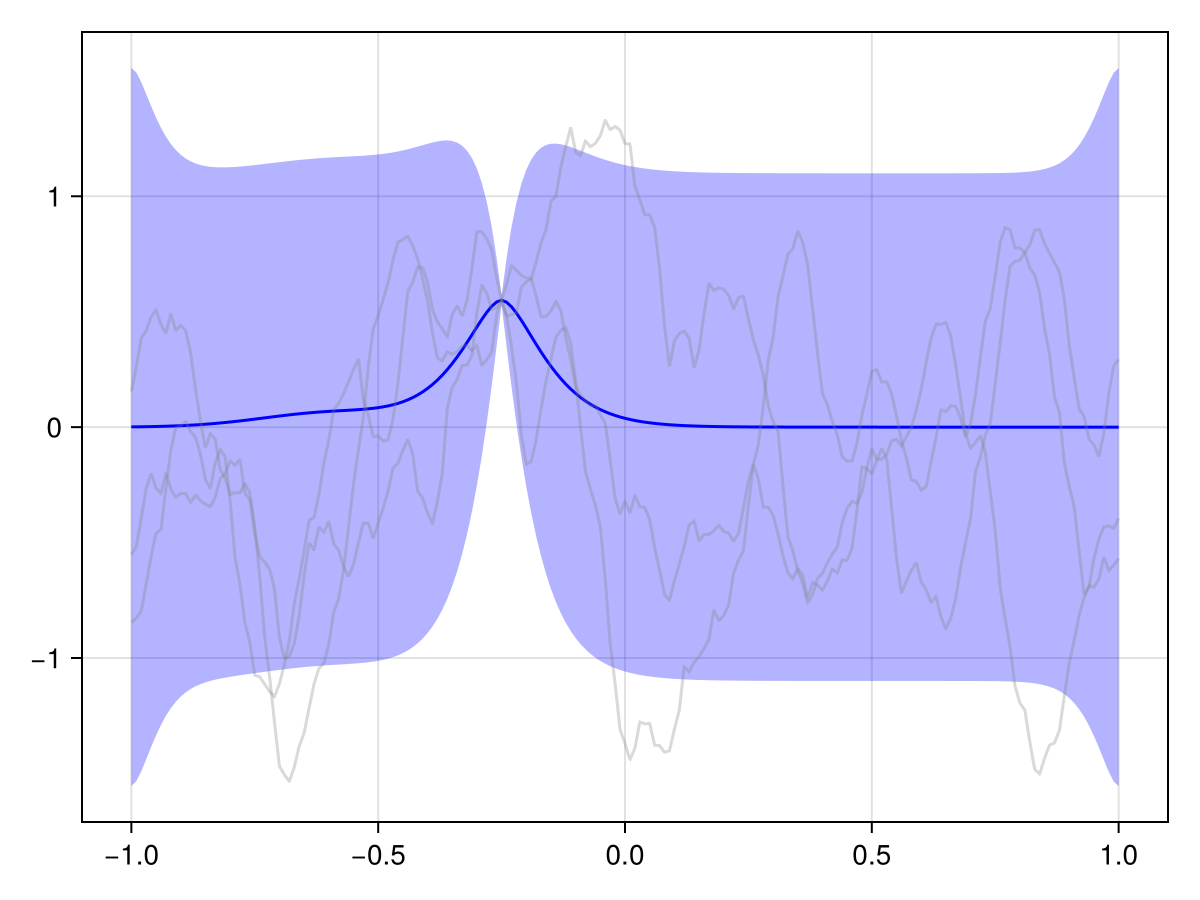

In [10]:
plot(x_st_kron_posterior, 2 * Nₜ ÷ 3)

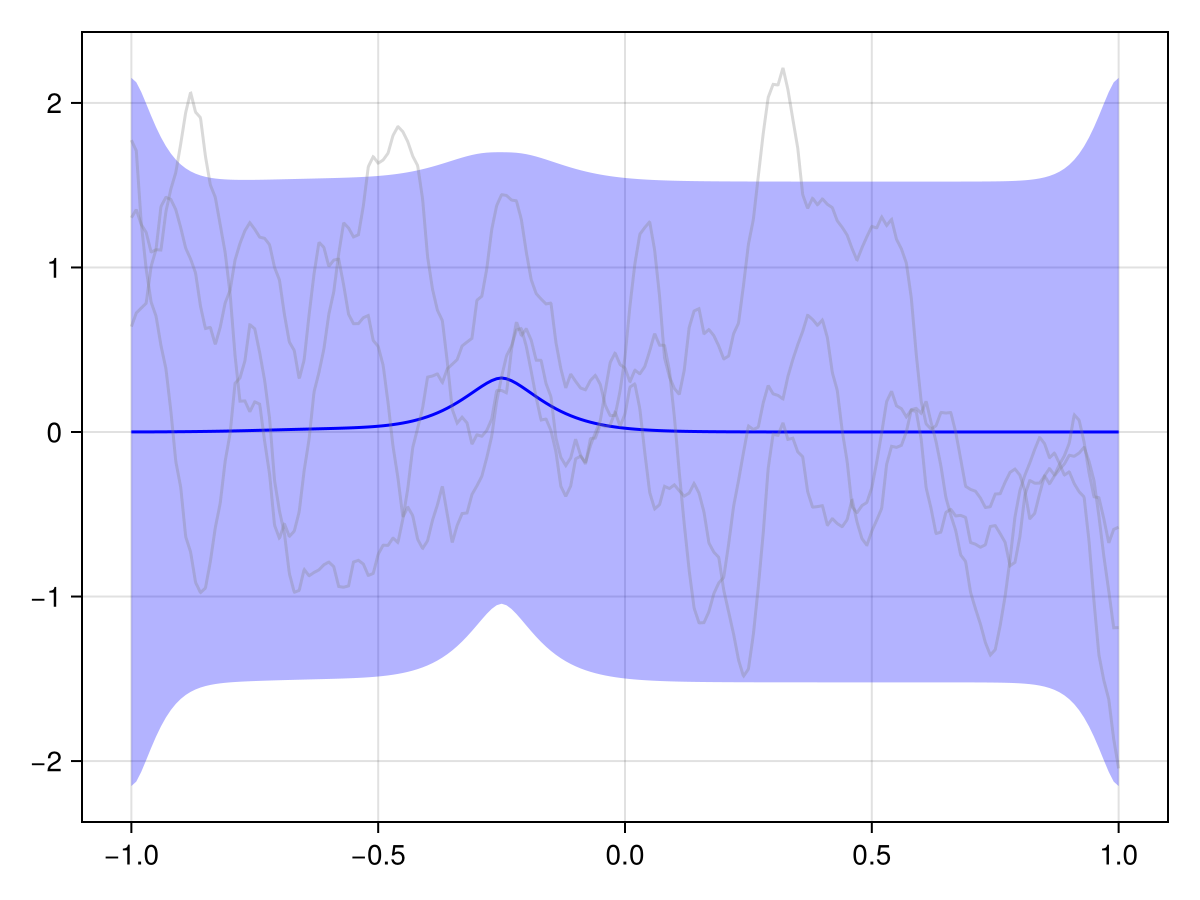

In [11]:
plot(x_st_kron_posterior, Nₜ)

We see that the effect of our observations effectively just "dies off" over
time.
And generally in spatiotemporal statistics, this is a fair assumption:
The further away in time we are from an observation, the less it should
influence our predictions.

But in our case, we know a bit more about the phenomenon at hand.
This is a river, and we know that it flows in a certain direction, and we
probably also roughly know the flow speed.
We should embed this information into our prior to get a more useful
posterior!

## Advection-diffusion priors
We can achieve this through a non-separable model that encodes these dynamics.
Concretely, we are going to consider an advection-diffusion SPDE as presented
in [Clarotto2024](@cite).

In [12]:
adv_diff_spde = AdvectionDiffusionSPDE{1}(
    γ = [-0.6],
    H = 0.1 * sparse(I, (1, 1)),
    τ = 0.1,
    α = 2 // 1,
    spatial_spde = spde_space,
    initial_spde = spde_space,
)

AdvectionDiffusionSPDE{1}(1.0, 2//1, sparse([1], [1], [0.1], 1, 1), [-0.6], 1.0, 0.1, MaternSPDE{1, Float64, Int64}(17.32050807568877, 3//2, 0.3, [1.0;;]), MaternSPDE{1, Float64, Int64}(17.32050807568877, 3//2, 0.3, [1.0;;]))

To discretize this SPDE, we only need a FEM discretization of space.
For time, we simply specify the discrete time points which are then used
internally for an implicit Euler scheme.

In [13]:
x_adv_diff = discretize(adv_diff_spde, disc, ts)

MetaGMRF{ImplicitEulerMetadata}
  Inner GMRF: GMRF{Float64}(n=14271, alg=LinearSolve.DefaultLinearSolver)
  Metadata: ImplicitEulerMetadata{1}(201 spatial × 71 time)

Condition on the initial observations:

In [14]:
x_adv_diff_posterior = condition_on_observations(x_adv_diff, A_all, Q_noise, ys_all)

MetaGMRF{ImplicitEulerMetadata}
  Inner GMRF: GMRF{Float64}(n=14271, alg=LinearSolve.DefaultLinearSolver)
  Metadata: ImplicitEulerMetadata{1}(201 spatial × 71 time)

Let's look at the dynamics of this posterior.

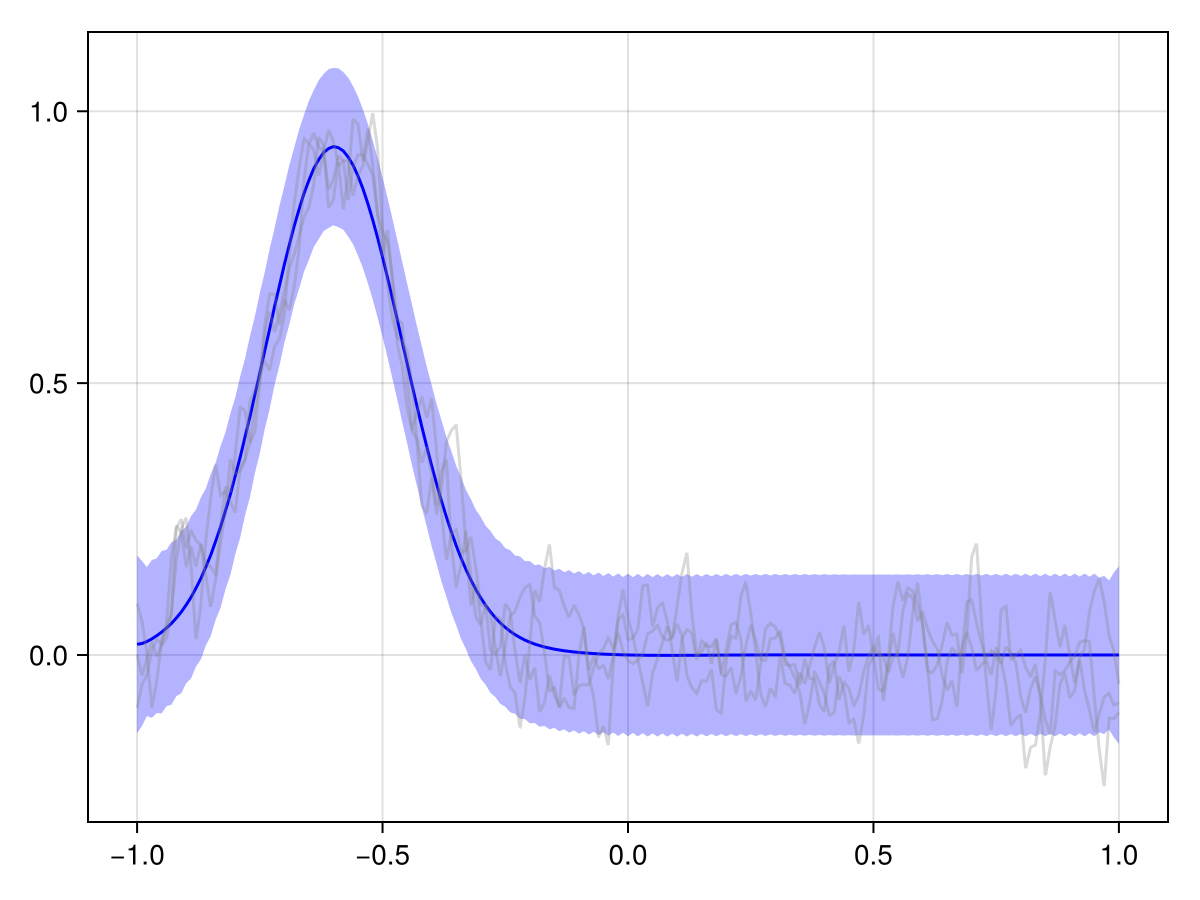

In [15]:
plot(x_adv_diff_posterior, t_initial_idx)

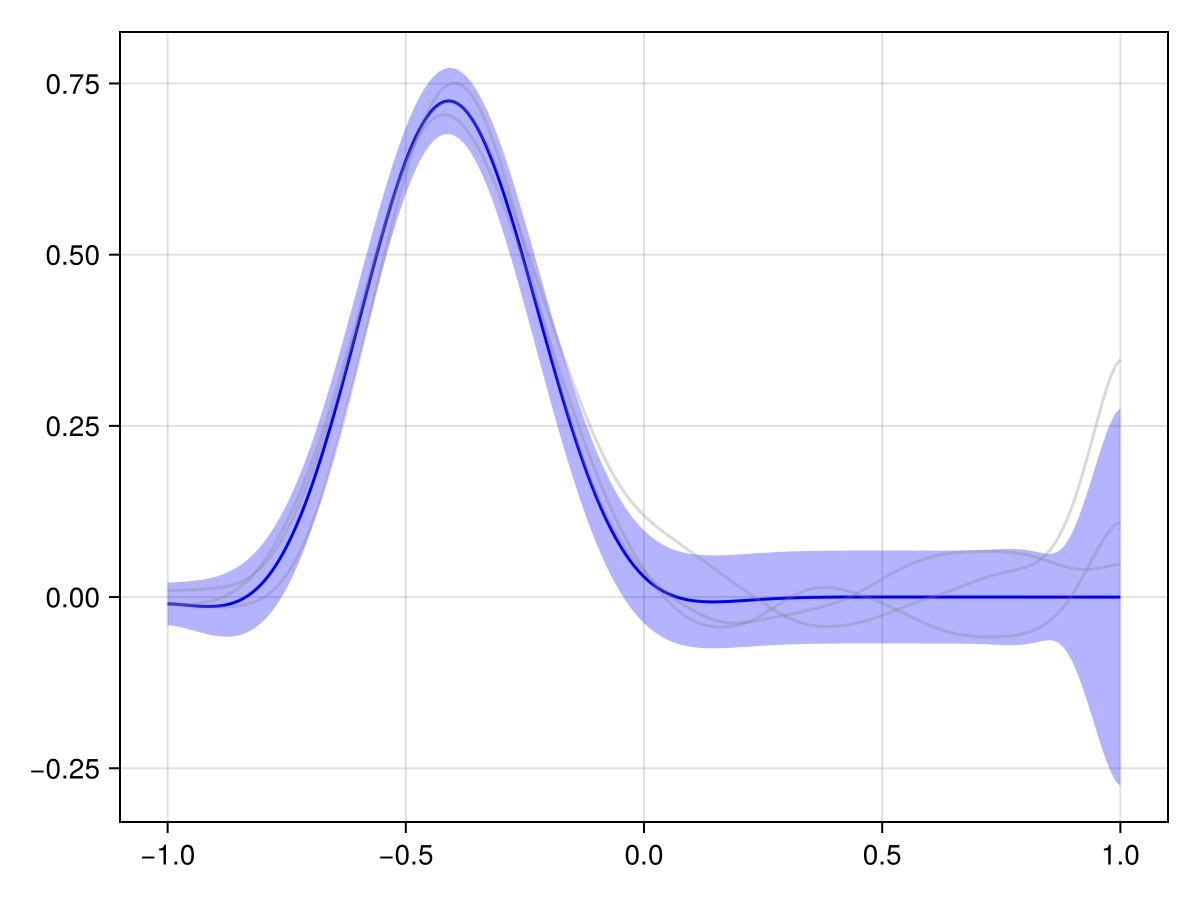

In [16]:
plot(x_adv_diff_posterior, Nₜ ÷ 3)

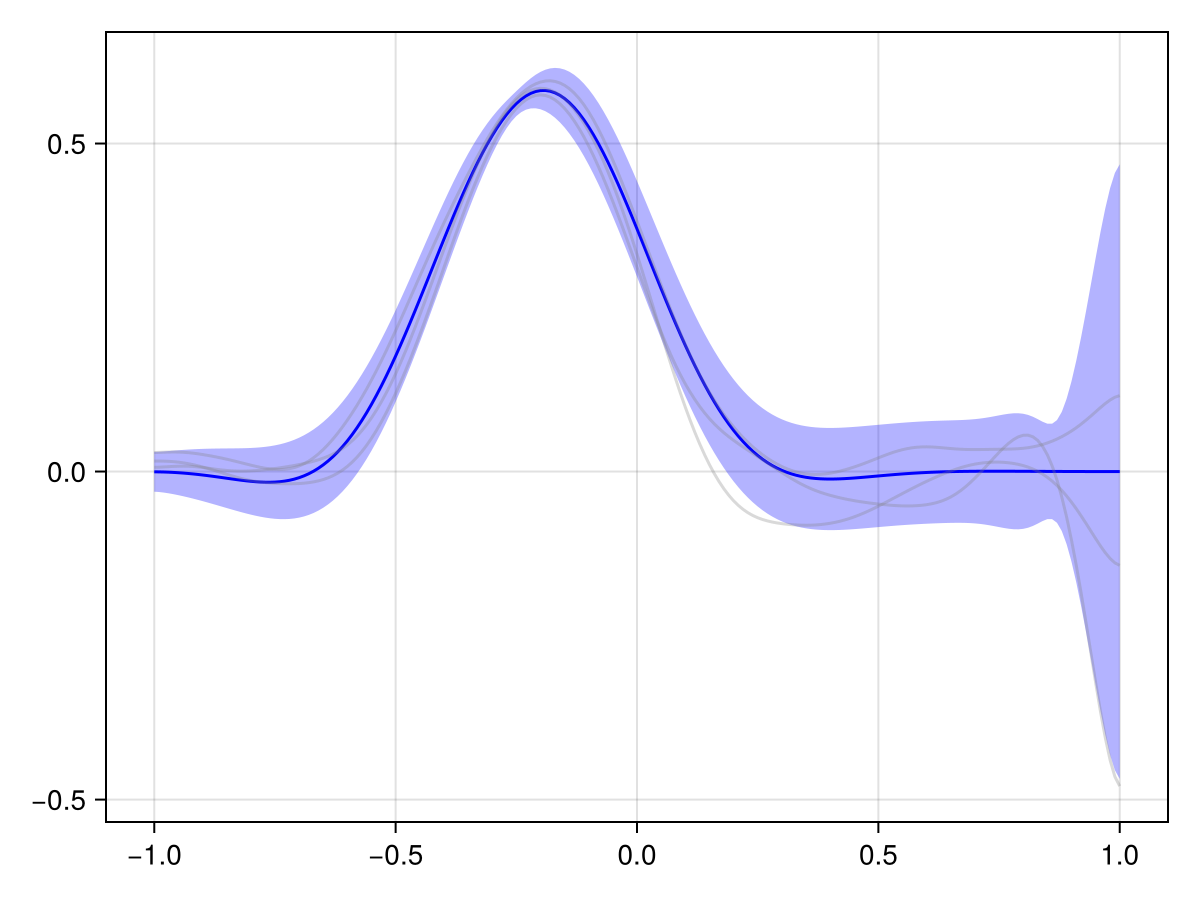

In [17]:
plot(x_adv_diff_posterior, 2 * Nₜ ÷ 3)

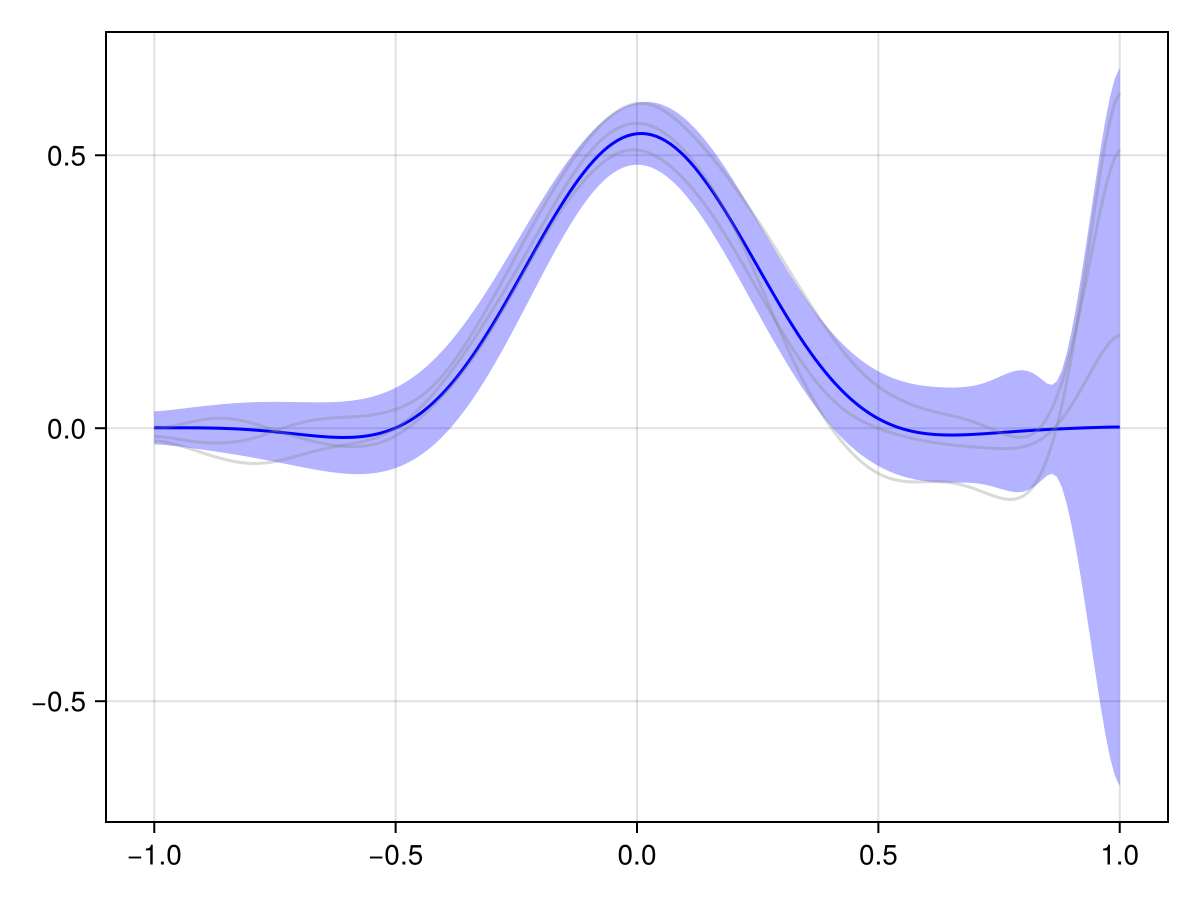

In [18]:
plot(x_adv_diff_posterior, Nₜ)

This looks much more reasonable!
We see that the pollutant is transported downstream over time, and the
observations at the later time point are consistent with this.

## Conclusion
We have seen how to model spatiotemporal phenomena using GMRFs.
We started with a simple separable model and then moved on to a more complex
advection-diffusion model.
The latter model was able to capture the dynamics of the river and the
pollutant transport much better.

As mentioned initially, this was a simple toy example.
But the underlying principles are the same for more complex problems.
In particular, all of the above should work the same for arbitrary spatial
meshes, as demonstrated e.g. in the tutorial
Spatial Modelling with SPDEs.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*